# One-Shot обучение сиамских сетей (Siamese Networks)

  [Ссылка на исходный репозиторий](https://github.com/harveyslash/Facial-Similarity-with-Siamese-Networks-in-Pytorch)

In [1]:
!git clone https://github.com/harveyslash/Facial-Similarity-with-Siamese-Networks-in-Pytorch.git

fatal: destination path 'Facial-Similarity-with-Siamese-Networks-in-Pytorch' already exists and is not an empty directory.


In [2]:
%cd /content/Facial-Similarity-with-Siamese-Networks-in-Pytorch

/content/Facial-Similarity-with-Siamese-Networks-in-Pytorch


## Импорты библиотек

In [3]:
%matplotlib inline
import torchvision
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import torchvision.utils
import numpy as np
import random
from PIL import Image
import torch
from torch.autograd import Variable
import PIL.ImageOps
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

## Вспомогательные функции

In [4]:
def imshow(img,text=None,should_save=False):
    npimg = img.numpy()
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic', fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

def show_plot(iteration,loss):
    plt.plot(iteration,loss)
    plt.show()

## Класс конфигурации

In [5]:
class Config():
    training_dir = "./data/faces/training/"
    testing_dir = "./data/faces/testing/"
    train_batch_size = 64
    train_number_epochs = 100

## Пользовательский класс SiameseNetworkDataset
Этот класс генерирует пару изображений и метку: 0 для пары изображений одного и того же человека и 1 для пары изоражений разных людей

In [6]:
class SiameseNetworkDataset(Dataset):

    def __init__(self,imageFolderDataset,transform=None,should_invert=True):
        self.imageFolderDataset = imageFolderDataset
        self.transform = transform
        self.should_invert = should_invert

    def __getitem__(self,index):
        img0_tuple = random.choice(self.imageFolderDataset.imgs)
        # нам нужно убедиться, что примерно 50% изображений относятся к одному классу
        should_get_same_class = random.randint(0, 1)
        if should_get_same_class:
            while True:
                # продолжаем цикл, пока не найдем изображение того же класса
                img1_tuple = random.choice(self.imageFolderDataset.imgs)
                if img0_tuple[1] == img1_tuple[1]:
                    break
        else:
            while True:
                # продолжаем цикл, пока не найдем изображение другого класса
                img1_tuple = random.choice(self.imageFolderDataset.imgs)
                if img0_tuple[1] != img1_tuple[1]:
                    break

        img0 = Image.open(img0_tuple[0])
        img1 = Image.open(img1_tuple[0])
        img0 = img0.convert("L")
        img1 = img1.convert("L")

        if self.should_invert:
            img0 = PIL.ImageOps.invert(img0)
            img1 = PIL.ImageOps.invert(img1)

        if self.transform is not None:
            img0 = self.transform(img0)
            img1 = self.transform(img1)

        return img0, img1, torch.from_numpy(np.array([int(img1_tuple[1] != img0_tuple[1])],dtype=np.float32))

    def __len__(self):
        return len(self.imageFolderDataset.imgs)

## Использование Image Folder dataset

In [7]:
folder_dataset = dset.ImageFolder(root=Config.training_dir)

In [8]:
siamese_dataset = SiameseNetworkDataset(imageFolderDataset=folder_dataset,
                                        transform=transforms.Compose([transforms.Resize((100, 100)),
                                                                      transforms.ToTensor()
                                                                      ]),
                                        should_invert=False)

## Визуализация некоторых примеров
Верхняя строка и нижняя строка любого столбца - это одна пара. 0 и 1 соответствуют столбцу изображения.
1 указывает на несхожесть, а 0 указывает на схожесть.

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


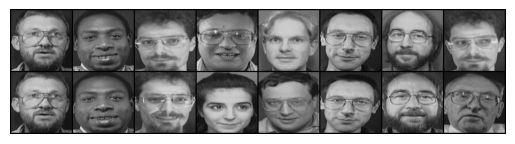

[[0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [0.]
 [0.]
 [1.]]


In [9]:
vis_dataloader = DataLoader(siamese_dataset,
                        shuffle=True,
                        num_workers=8,
                        batch_size=8)
dataiter = iter(vis_dataloader)


example_batch = next(dataiter)
concatenated = torch.cat((example_batch[0], example_batch[1]), 0)
imshow(torchvision.utils.make_grid(concatenated))
print(example_batch[2].numpy())

## Создание модели нейронной сети
Будем использовать стандартную сверточную нейронную сеть

In [10]:
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        self.cnn1 = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(1, 4, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(4),

            nn.ReflectionPad2d(1),
            nn.Conv2d(4, 8, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(8),


            nn.ReflectionPad2d(1),
            nn.Conv2d(8, 8, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(8),


        )

        self.fc1 = nn.Sequential(
            nn.Linear(8*100*100, 500),
            nn.ReLU(inplace=True),

            nn.Linear(500, 500),
            nn.ReLU(inplace=True),

            nn.Linear(500, 5))

    def forward_once(self, x):
        output = self.cnn1(x)
        output = output.view(output.size()[0], -1)
        output = self.fc1(output)
        return output

    def forward(self, input1, input2):
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)
        return output1, output2

## Функция потерь Contrastive Loss

In [11]:
class ContrastiveLoss(torch.nn.Module):
    """
    Функция потерь Contrastive Loss.
    Основано на: http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    """

    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2, keepdim=True)
        loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                      (label) * torch.pow(
                                          torch.clamp(
                                              self.margin - euclidean_distance,
                                              min=0.0),
                                          2))


        return loss_contrastive

## Обучение модели

In [12]:
train_dataloader = DataLoader(siamese_dataset,
                        shuffle=True,
                        num_workers=8,
                        batch_size=Config.train_batch_size)

In [13]:
net = SiameseNetwork().cuda()
criterion = ContrastiveLoss()
optimizer = optim.Adam(net.parameters(), lr=0.0005)

In [14]:
counter = []
loss_history = []
iteration_number = 0

Epoch number 0
 Current loss 1.531916856765747

Epoch number 1
 Current loss 4.9250335693359375

Epoch number 2
 Current loss 3.9389548301696777

Epoch number 3
 Current loss 1.8369874954223633

Epoch number 4
 Current loss 0.7764498591423035

Epoch number 5
 Current loss 0.6003145575523376

Epoch number 6
 Current loss 0.5226118564605713

Epoch number 7
 Current loss 0.5796244144439697

Epoch number 8
 Current loss 0.5250656604766846

Epoch number 9
 Current loss 0.42496949434280396

Epoch number 10
 Current loss 0.3626251220703125

Epoch number 11
 Current loss 0.3570243716239929

Epoch number 12
 Current loss 0.19730618596076965

Epoch number 13
 Current loss 0.2415313720703125

Epoch number 14
 Current loss 0.2056962251663208

Epoch number 15
 Current loss 0.11440525203943253

Epoch number 16
 Current loss 0.12294615060091019

Epoch number 17
 Current loss 0.14455878734588623

Epoch number 18
 Current loss 0.10091066360473633

Epoch number 19
 Current loss 0.056001439690589905

Epo

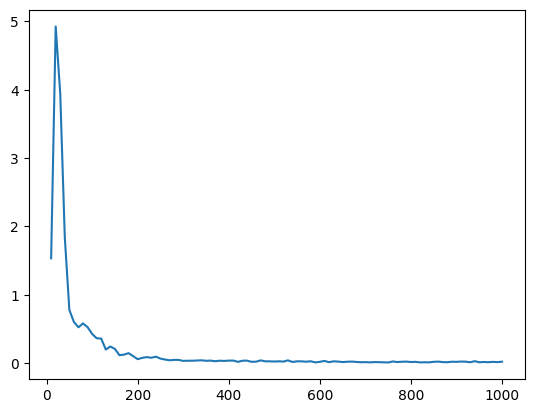

In [15]:
for epoch in range(0, Config.train_number_epochs):
    for i, data in enumerate(train_dataloader, 0):
        img0, img1, label = data
        img0, img1, label = img0.cuda(), img1.cuda(), label.cuda()
        optimizer.zero_grad()
        output1, output2 = net(img0, img1)
        loss_contrastive = criterion(output1, output2, label)
        loss_contrastive.backward()
        optimizer.step()
        if i % 10 == 0 :
            print("Epoch number {}\n Current loss {}\n".format(epoch, loss_contrastive.item()))
            iteration_number += 10
            counter.append(iteration_number)
            loss_history.append(loss_contrastive.item())
show_plot(counter, loss_history)

## Тестирование модели
Последние 3 субъекта были исключены из обучения и будут использованы для тестирования. Расстояние между каждой парой изображений обозначает степень схожести, которую модель нашла между двумя изображениями. Меньшее значение означает, что она сочла их более похожими, в то время как более высокие значения указывают на то, что она сочла их несхожими.

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


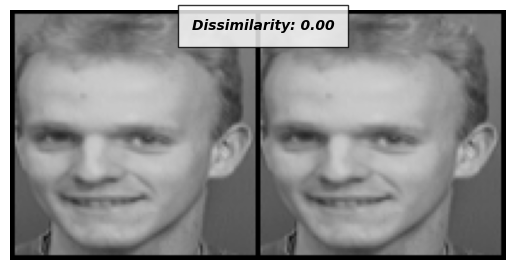

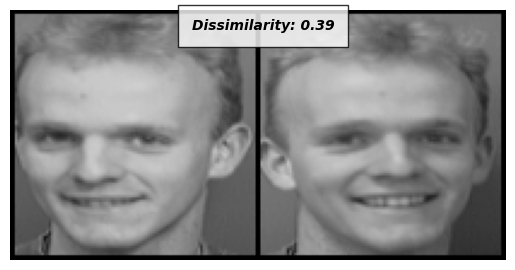

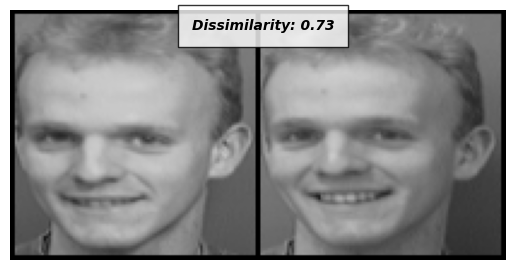

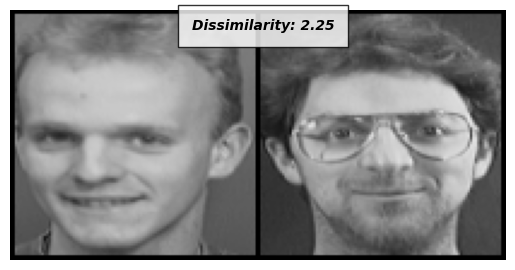

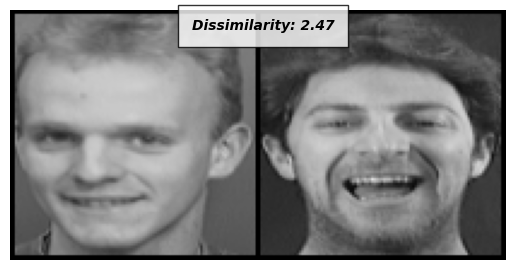

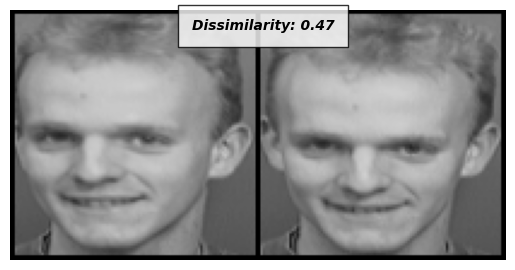

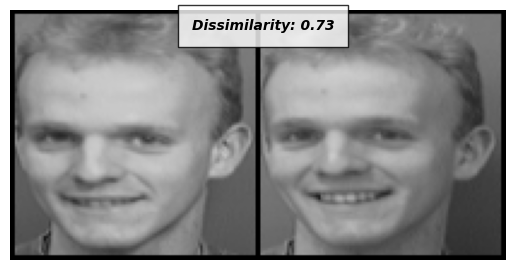

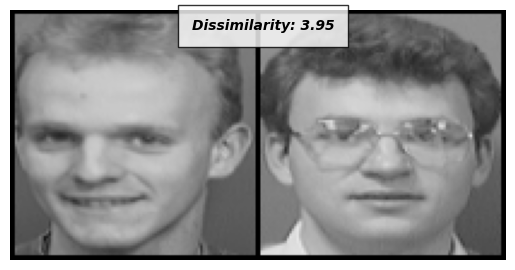

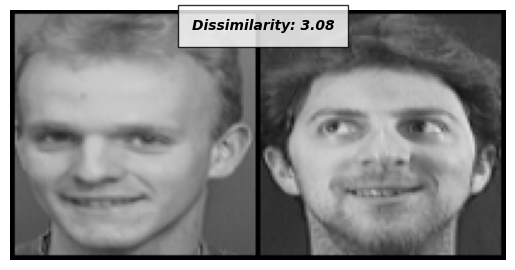

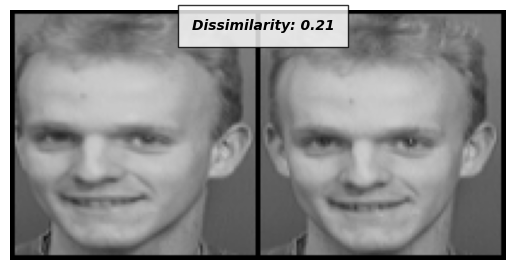

In [16]:
folder_dataset_test = dset.ImageFolder(root=Config.testing_dir)
siamese_dataset = SiameseNetworkDataset(imageFolderDataset=folder_dataset_test,
                                        transform=transforms.Compose([transforms.Resize((100, 100)),
                                                                      transforms.ToTensor()
                                                                      ]),
                                        should_invert=False)

test_dataloader = DataLoader(siamese_dataset, num_workers=6, batch_size=1, shuffle=True)
dataiter = iter(test_dataloader)
x0, _, _ = next(dataiter)

for i in range(10):
    _, x1, label2 = next(dataiter)
    concatenated = torch.cat((x0, x1), 0)

    output1, output2 = net(Variable(x0).cuda(), Variable(x1).cuda())
    euclidean_distance = F.pairwise_distance(output1, output2)
    imshow(torchvision.utils.make_grid(concatenated), 'Dissimilarity: {:.2f}'.format(euclidean_distance.item()))

